In [35]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/brandonmanley/Desktop/PhD/dijet_dsa')
import dsa_mc.dijet as dijet
import random
from IPython.display import display, Math

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14  
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

In [21]:
# get spectra of dsa

values = {}
values['pT'] = np.linspace(1, 50, 100)
values['s'] = np.linspace(100, 300, 100)
values['Q'] = np.linspace(4, 10, 100)

def get_base_kins():
    base_kins = dijet.Kinematics(Q=8, z=0.4, x=0.01, s=100**2, pT=30.0, delta=0.0, phi_Dp=0.0, phi_kp=0.0)
    base_kins.y = (base_kins.Q**2)/(base_kins.s*base_kins.x)
    assert base_kins.y <= 1, 'y > 1'
    return base_kins

kins = get_base_kins()

djs = {}
djs['dis+sidis'] = dijet.DIJET(old_rap=False)
djs['+pp'] = dijet.DIJET(old_rap=False)
djs['+pp'].load_params('replica_params_pp.csv')

denom = {}
num = {}

for fit in ['dis+sidis', '+pp']:
    denom[fit] = {}
    num[fit] = {}

    for var in ['pT', 's', 'Q']:
        denom[fit][var] = []
        num[fit][var] = []

for irep in range(1, 398):
    # if irep > 100: break
    print(irep)
    # nrep = random.randint(1,398)

    for fit in ['dis+sidis', '+pp']:
        djs[fit].set_params(irep)
        
        num_rep = []
        kins = get_base_kins()
        for pT in values['pT']:
            kins.pT = pT
            if irep == 1:
                denom[fit]['pT'].append(djs[fit].get_xsec(kins, 'unpolarized', 'dx'))
            num_rep.append(djs[fit].get_xsec(kins, 'DSA', 'dx')) 
        num[fit]['pT'].append(num_rep)
    
        num_rep = []
        kins = get_base_kins()
        for roots in values['s']:
            kins.s = roots**2
            kins.y = (kins.Q**2)/(kins.s*kins.x)
            assert kins.y <= 1, 'y > 1'
            
            if irep == 1:
                denom[fit]['s'].append(djs[fit].get_xsec(kins, 'unpolarized', 'dx'))
            num_rep.append(djs[fit].get_xsec(kins, 'DSA', 'dx'))
        num[fit]['s'].append(num_rep)
    
        num_rep = []
        kins = get_base_kins()
        for Q in values['Q']:
            kins.Q = Q
            kins.y = (kins.Q**2)/(kins.s*kins.x)
            assert kins.y <= 1, 'y > 1'
            
            if irep == 1:
                denom[fit]['Q'].append(djs[fit].get_xsec(kins, 'unpolarized', 'dx'))
            num_rep.append(djs[fit].get_xsec(kins, 'DSA', 'dx'))
        num[fit]['Q'].append(num_rep)

    # np.save('predictions/dsa_denom.npy', denom, allow_pickle=True)
    # np.save('predictions/dsa_num.npy', num, allow_pickle=True)
    
    

loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-etamax15-rc/
loaded params from replica_params_old.csv
loaded replica 1
loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-etamax15-rc/
loaded params from replica_params_old.csv
loaded replica 1
loaded params from replica_params_pp.csv
1
loaded replica 1


KeyboardInterrupt: 

In [23]:
# load reps and calc bands for numerator

num_data = np.load('predictions/dsa_num.npy', allow_pickle=True).item()
denom_data = np.load('predictions/dsa_denom.npy', allow_pickle=True).item()

denom_bad_data = np.load('predictions/dsa_denom_old_rap.npy', allow_pickle=True).item()
num_bad_data = np.load('predictions/dsa_num_old_rap.npy', allow_pickle=True).item()

confid = 68
num_bands = {}
ratio_bands = {}
num_bad_bands = {}
ratio_bad_bands = {}

for fit in ['dis+sidis', '+pp']:
    num_bands[fit] = {}
    ratio_bands[fit] = {}
    
    num_bad_bands[fit] = {}
    ratio_bad_bands[fit] = {}
    
    for obj in ['lower', 'upper', 'mean']:
        num_bands[fit][obj] = {}
        ratio_bands[fit][obj] = {}

        num_bad_bands[fit][obj] = {}
        ratio_bad_bands[fit][obj] = {}


    for var in ['pT', 's', 'Q']:
        num_bands[fit]['lower'][var] = np.percentile(np.abs(num_data[fit][var]), 0.5*(100-confid), axis=0)
        num_bands[fit]['upper'][var] = np.percentile(np.abs(num_data[fit][var]), 100 - 0.5*(100-confid), axis=0)
        num_bands[fit]['mean'][var] = np.mean(np.abs(num_data[fit][var]), axis=0)

        ratio_bands[fit]['lower'][var] = np.percentile(np.array(num_data[fit][var])/np.array(denom_data[fit][var]), 0.5*(100-confid), axis=0)
        ratio_bands[fit]['upper'][var] = np.percentile(np.array(num_data[fit][var])/np.array(denom_data[fit][var]), 100 - 0.5*(100-confid), axis=0)
        ratio_bands[fit]['mean'][var] = np.mean(np.array(num_data[fit][var])/np.array(denom_data[fit][var]), axis=0)

        num_bad_bands[fit]['lower'][var] = np.percentile(np.abs(num_bad_data[fit][var]), 0.5*(100-confid), axis=0)
        num_bad_bands[fit]['upper'][var] = np.percentile(np.abs(num_bad_data[fit][var]), 100 - 0.5*(100-confid), axis=0)
        num_bad_bands[fit]['mean'][var] = np.mean(np.abs(num_bad_data[fit][var]), axis=0)

        ratio_bad_bands[fit]['lower'][var] = np.percentile(np.array(num_bad_data[fit][var])/np.array(denom_bad_data[fit][var]), 0.5*(100-confid), axis=0)
        ratio_bad_bands[fit]['upper'][var] = np.percentile(np.array(num_bad_data[fit][var])/np.array(denom_bad_data[fit][var]), 100 - 0.5*(100-confid), axis=0)
        ratio_bad_bands[fit]['mean'][var] = np.mean(np.array(num_bad_data[fit][var])/np.array(denom_bad_data[fit][var]), axis=0)



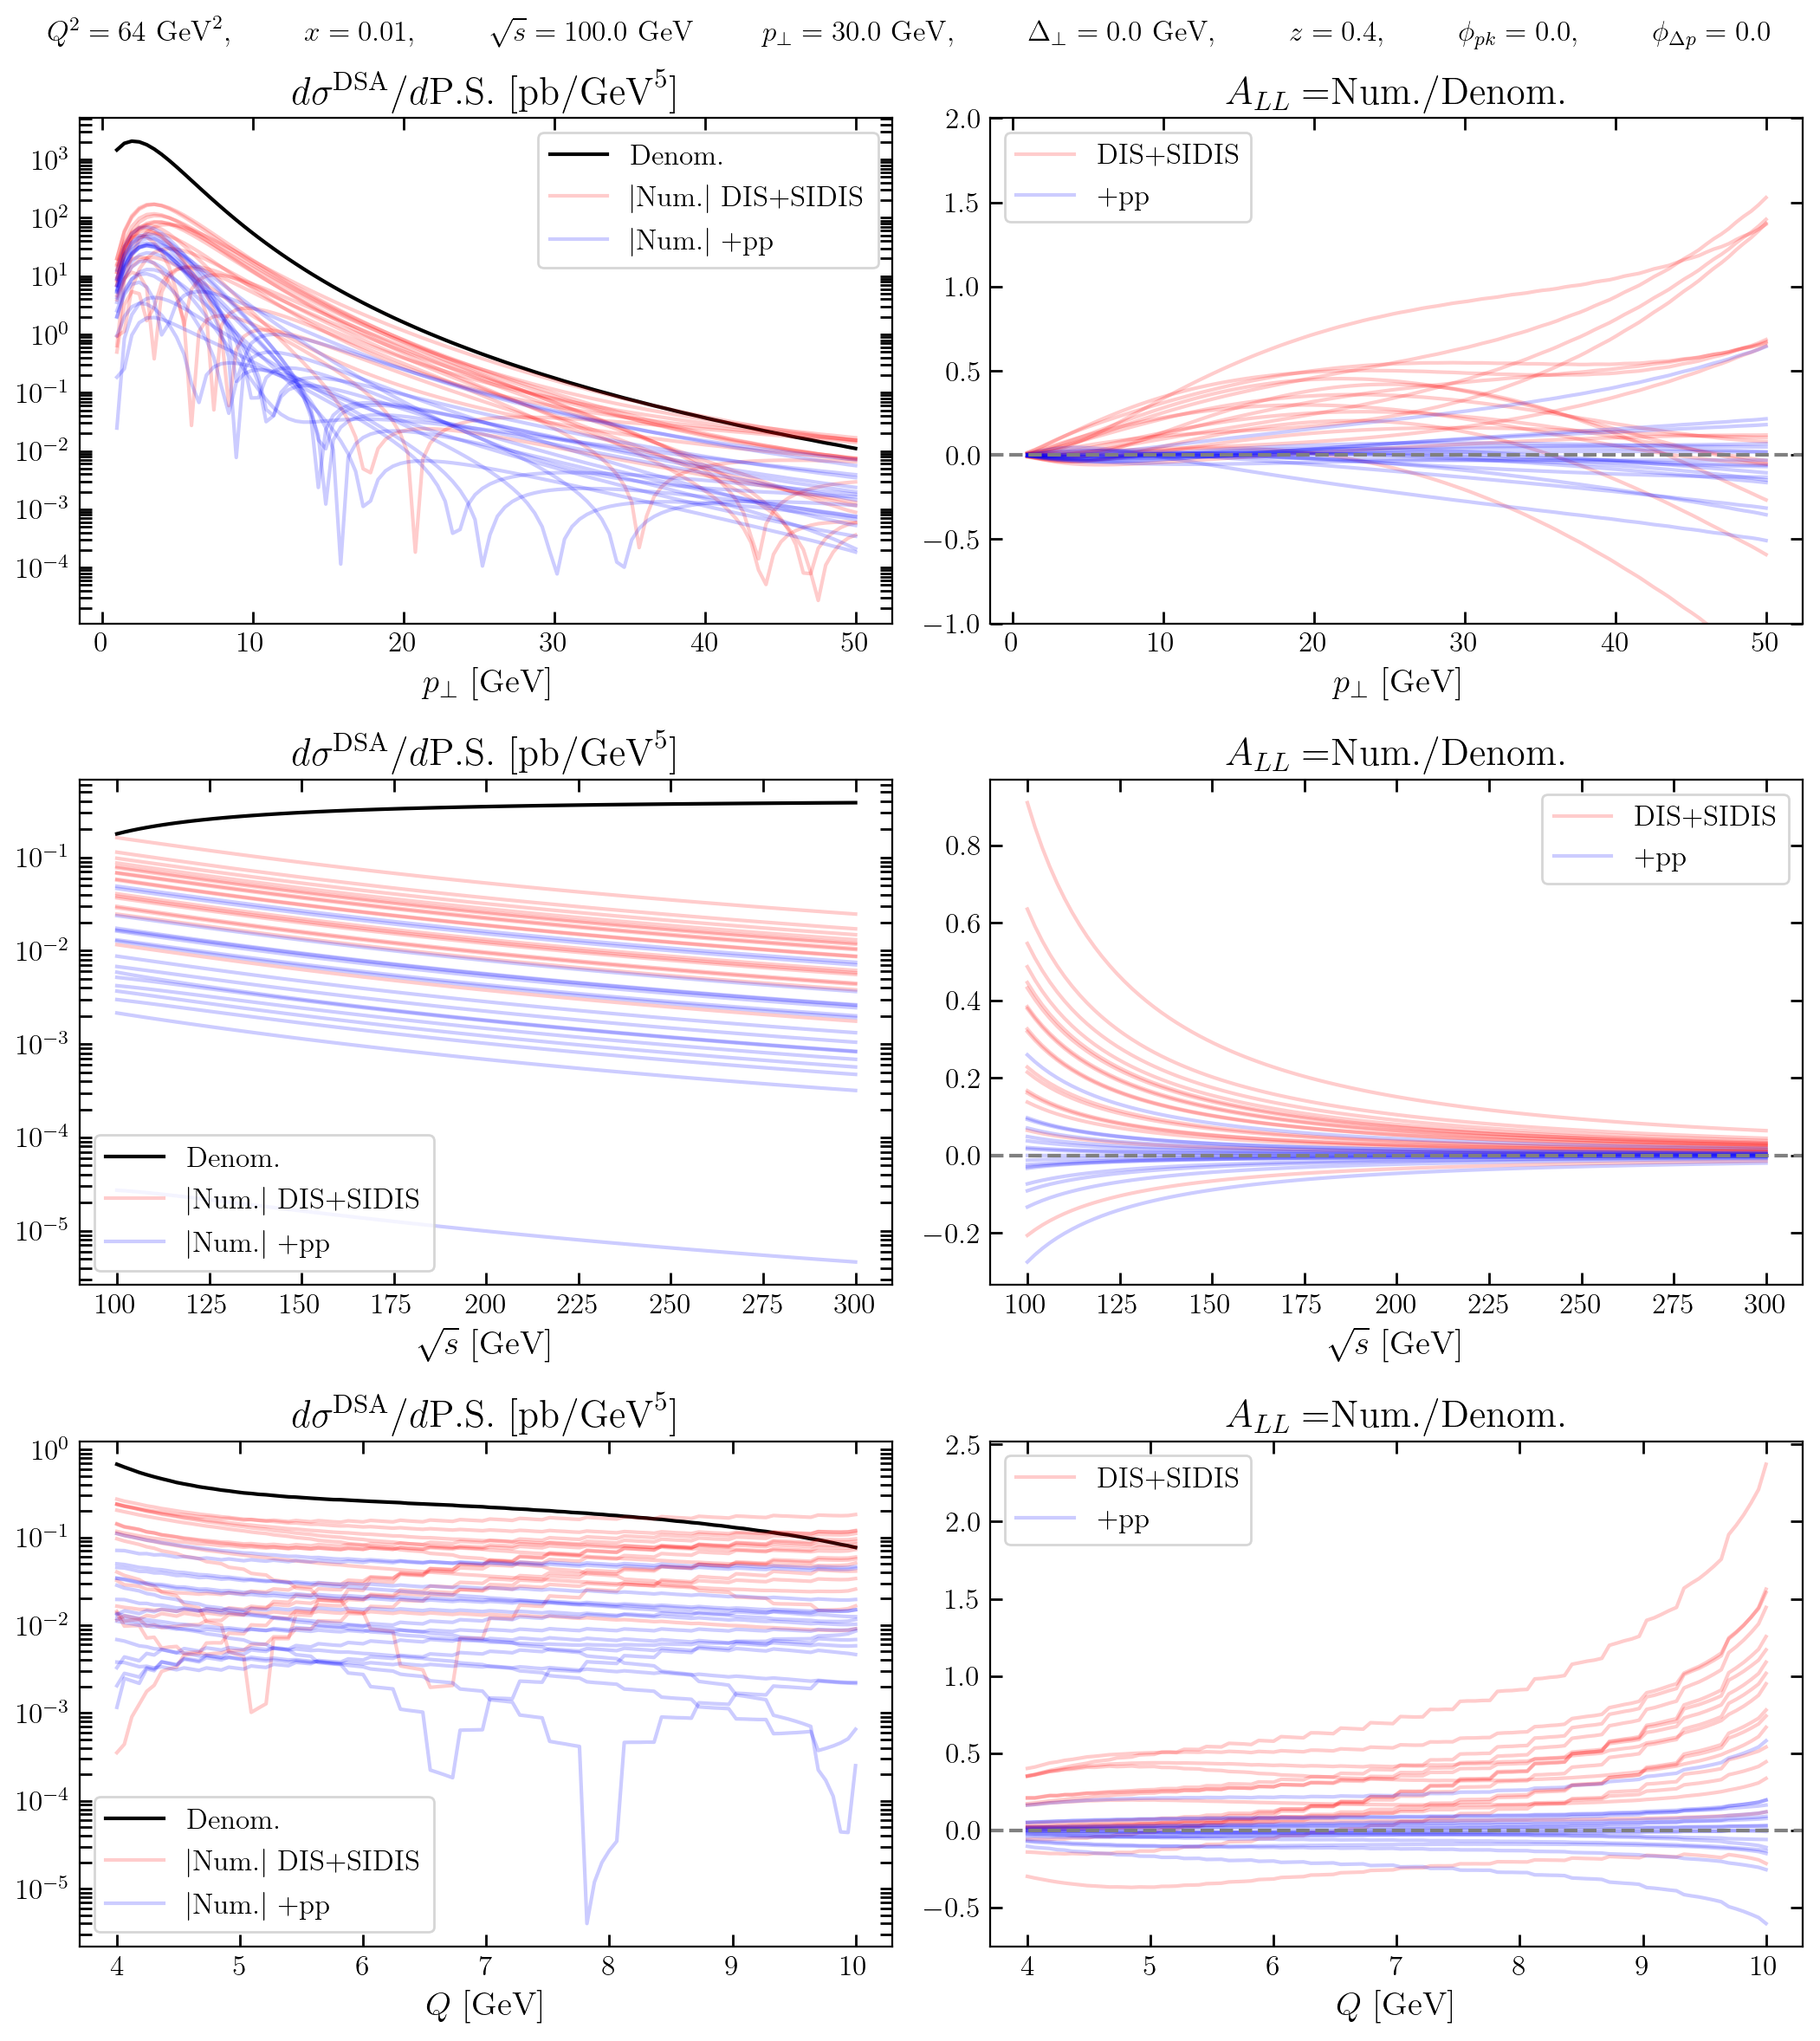

In [33]:
# plot spectra

asp_ratio = 4/3
psize = 4
fig, axs = plt.subplots(3, 2, figsize=(asp_ratio*psize*2, psize*3))

base_kins = get_base_kins()
base_str = fr'$Q^2={round(base_kins.Q**2,1)} \,\, \mathrm{{GeV}}^2, \hspace{{1cm}} x={base_kins.x}, \hspace{{1cm}}\sqrt{{s}}={np.sqrt(base_kins.s)} \,\, \mathrm{{GeV}}$'
base_str += fr'$\hspace{{1cm}} p_\perp ={base_kins.pT}\,\, \mathrm{{GeV}}, \hspace{{1cm}} \Delta_\perp ={base_kins.delta}\,\, \mathrm{{GeV}}, \hspace{{1cm}} z={base_kins.z}, \hspace{{1cm}} \phi_{{pk}}={base_kins.phi_kp}, \hspace{{1cm}}\phi_{{\Delta p}}={base_kins.phi_Dp}$'
fig.suptitle(base_str, fontsize=12)

plot_bands = False
colors = ['red', 'blue']
labels = ['DIS+SIDIS', '+pp']

for ivar, var in enumerate(['pT', 's', 'Q']):
    
    axs[ivar,0].plot(values[var], denom_data['dis+sidis'][var], label = 'Denom.', color='black')
    # axs[ivar,0].plot(values[var], denom_bad_data['dis+sidis'][var], label = 'Denom. - using log(1/x)', color='black', linestyle='--')

    for ifit, fit in enumerate(['dis+sidis', '+pp']):
        # if ifit > 0: continue

        if plot_bands: 
            axs[ivar,0].plot(values[var], num_bands[fit]['mean'][var], color=colors[ifit])
            axs[ivar,0].fill_between(values[var], num_bands[fit]['lower'][var], num_bands[fit]['upper'][var], color=colors[ifit], alpha=0.3, label=labels[ifit])

            axs[ivar,1].plot(values[var], ratio_bands[fit]['mean'][var], color=colors[ifit])
            axs[ivar,1].fill_between(values[var], ratio_bands[fit]['lower'][var], ratio_bands[fit]['upper'][var], color=colors[ifit], alpha=0.3, label=labels[ifit])

            # axs[ivar,0].plot(values[var], num_bad_bands[fit]['mean'][var], color='gray')
            # axs[ivar,0].fill_between(values[var], num_bad_bands[fit]['lower'][var], num_bad_bands[fit]['upper'][var], color='gray', alpha=0.3, label='ln(1/x)')
            
            # axs[ivar,1].plot(values[var], ratio_bad_bands[fit]['mean'][var], color='gray')
            # axs[ivar,1].fill_between(values[var], ratio_bad_bands[fit]['lower'][var], ratio_bad_bands[fit]['upper'][var], color='gray', alpha=0.3, label='ln(1/x)')

        else:
            for id, rep in enumerate(num_data[fit][var]):
                if id == 0:
                    axs[ivar,0].plot(values[var], np.abs(rep), color=colors[ifit], alpha=0.2, label=rf'$|\mathrm{{Num.}}|$ {labels[ifit]}')
                else:
                    axs[ivar,0].plot(values[var], np.abs(rep), color=colors[ifit], alpha=0.2)
    
                if id == 0:
                    axs[ivar,1].plot(values[var], np.array(rep)/np.array(denom_data['dis+sidis'][var]), color=colors[ifit], alpha=0.2, label=labels[ifit])
                else:
                    axs[ivar,1].plot(values[var], np.array(rep)/np.array(denom_data['dis+sidis'][var]), color=colors[ifit], alpha=0.2)

    
axs[0,0].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0,0].set_title(fr'$d\sigma^{{\mathrm{{DSA}}}}/d \mathrm{{P.S.}} \,\,[\mathrm{{pb}}/ \mathrm{{GeV}}^5]$')
axs[0,0].legend()
axs[0,0].semilogy()
# ax.set_ylim([-0.000005, 0.000005])
axs[0,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[0,1].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0,1].set_title(fr'$A_{{LL}}=$Num./Denom.')
# axs[0,1].axhline(y=1, color='grey', linestyle=':')
axs[0,1].axhline(y=0, color='grey', linestyle='--')
# axs[0,1].axhline(y=-1, color='grey', linestyle=':')
# axs[1].semilogy()
axs[0,1].legend()
axs[0,1].set_ylim([-1, 2])
axs[0,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[1,0].set_xlabel(r'$\sqrt{s}$ [GeV]')
axs[1,0].set_title(fr'$d\sigma^{{\mathrm{{DSA}}}}/d \mathrm{{P.S.}} \,\,[\mathrm{{pb}}/ \mathrm{{GeV}}^5]$')
axs[1,0].legend()
axs[1,0].semilogy()
# ax.set_ylim([-0.000005, 0.000005])
axs[1,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[1,1].set_xlabel(r'$\sqrt{s}$ [GeV]')
axs[1,1].set_title(fr'$A_{{LL}}=$Num./Denom.')
# axs[1,1].axhline(y=1, color='grey', linestyle=':')
axs[1,1].axhline(y=0, color='grey', linestyle='--')
# axs[1,1].axhline(y=-1, color='grey', linestyle=':')
# axs[1].semilogy()
axs[1,1].legend()
# axs[1,1].set_ylim([-1.1, 1.1])
axs[1,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[2,0].set_xlabel(r'$Q$ [GeV]')
axs[2,0].set_title(fr'$d\sigma^{{\mathrm{{DSA}}}}/d \mathrm{{P.S.}} \,\,[\mathrm{{pb}}/ \mathrm{{GeV}}^5]$')
axs[2,0].legend()
axs[2,0].semilogy()
# ax.set_ylim([-0.000005, 0.000005])
axs[2,0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[2,1].set_xlabel(r'$Q$ [GeV]')
axs[2,1].set_title(fr'$A_{{LL}}=$Num./Denom.')
# axs[2,1].axhline(y=1, color='grey', linestyle=':')
axs[2,1].axhline(y=0, color='grey', linestyle='--')
# axs[2,1].axhline(y=-1, color='grey', linestyle=':')
# axs[1].semilogy()
axs[2,1].legend()
# axs[2,1].set_ylim([-1.1, 1.1])
axs[2,1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


plt.tight_layout()
plt.show()

if plot_bands:
    fig.savefig('plots/dsa_band_bad_compare.pdf', dpi=400, bbox_inches="tight")
else:
    fig.savefig('plots/dsa_lines.pdf', dpi=400, bbox_inches="tight")



In [11]:
# calc pdfs + oam distributions

hel_replicas = {}
oam_replicas = {}
int_replicas = {}

for fit in ['dis+sidis', '+pp']:
    hel_replicas[fit] = {}
    oam_replicas[fit] = {}
    int_replicas[fit] = {}
    for func in ['g1', 'xsigma', 'xg']:
        hel_replicas[fit][func] = []
    for func in ['xLq', 'xLG']:
        oam_replicas[fit][func] = []
    for func in ['DeltaSigma', 'DeltaG', 'Lq', 'LG', 'oam', 'helicity']:
        int_replicas[fit][func] = []
     
x_values = np.logspace(-4, -1, num=50)
hel_kins = dijet.Kinematics(Q=np.sqrt(10), x=0.005)

djs = {}
djs['dis+sidis'] = dijet.DIJET()
djs['+pp'] = dijet.DIJET()
djs['+pp'].load_params('replica_params_pp.csv')

for irep in range(1, 501):
    if irep > 100: break
    nrep = random.randint(1,398)

    for fit in ['dis+sidis', '+pp']:
        djs[fit].set_params(nrep)
        print(irep, nrep)
        
        rep = {}
        oam_rep = {}
        int_rep = {}
    
        for func in ['g1', 'xsigma', 'xg']:
            rep[func] = []

        for func in ['xLq', 'xLG']:
            oam_rep[func] = []

        for func in['DeltaSigma', 'DeltaG', 'Lq', 'LG', 'oam', 'helicity']:
            int_rep[func] = []
            
        for ix, x in enumerate(x_values):
            hel_kins.x = x
            
            g1_value = djs[fit].get_g1(hel_kins)
            xsigma_value = x*djs[fit].get_DeltaSigma(hel_kins)
            xg_value = x*djs[fit].get_DeltaG(hel_kins)
            xLq_value = x*djs[fit].get_Lsinglet(hel_kins)
            xLG_value = x*djs[fit].get_LG(hel_kins)

            integrated_DeltaSigma_value = djs[fit].get_IntegratedPDF(hel_kins, 'DeltaSigma', xmin=x)
            integrated_DeltaG_value = djs[fit].get_IntegratedPDF(hel_kins, 'DeltaG', xmin=x)
            integrated_Lq_value = djs[fit].get_IntegratedPDF(hel_kins, 'Lq', xmin=x)
            integrated_LG_value = djs[fit].get_IntegratedPDF(hel_kins, 'LG', xmin=x)
            integrated_helicity_value = djs[fit].get_IntegratedPDF(hel_kins, 'helicity', xmin=x)
            integrated_oam_value = djs[fit].get_IntegratedPDF(hel_kins, 'oam', xmin=x)
            
            rep['g1'].append(g1_value)
            rep['xsigma'].append(xsigma_value)
            rep['xg'].append(xg_value)
            oam_rep['xLq'].append(xLq_value)
            oam_rep['xLG'].append(xLG_value)

            int_rep['DeltaSigma'].append(integrated_DeltaSigma_value)
            int_rep['DeltaG'].append(integrated_DeltaG_value)
            int_rep['Lq'].append(integrated_Lq_value)
            int_rep['LG'].append(integrated_LG_value)
            int_rep['helicity'].append(integrated_helicity_value)
            int_rep['oam'].append(integrated_oam_value)

        for func in ['g1', 'xsigma', 'xg']:
            hel_replicas[fit][func].append(rep[func])

        for func in ['xLq', 'xLG']:
            oam_replicas[fit][func].append(oam_rep[func])

        for func in['DeltaSigma', 'DeltaG', 'Lq', 'LG', 'oam', 'helicity']:
            int_replicas[fit][func].append(int_rep[func])
                 

        np.save('predictions/ppdfs.npy', hel_replicas, allow_pickle=True)
        np.save('predictions/oams.npy', oam_replicas, allow_pickle=True)
        np.save('predictions/int_ppdfs.npy', int_replicas, allow_pickle=True)
        # np.save('predictions/dsa_num.npy', num, allow_pickle=True)
    

loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-etamax15-rc/
loaded params from replica_params_old.csv
loaded replica 1
loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-etamax15-rc/
loaded params from replica_params_old.csv
loaded replica 1
loaded params from replica_params_pp.csv
loaded replica 205
1 205
loaded replica 205
1 205
loaded replica 61
2 61
loaded replica 61
2 61
loaded replica 276
3 276
loaded replica 276
3 276
loaded replica 6
4 6
loaded replica 6
4 6
loaded replica 287
5 287
loaded replica 287
5 287
loaded replica 187
6 187
loaded replica 187
6 187
loaded replica 313
7 313
loaded replica 313
7 313
loaded replica 271
8 271
loaded replica 271
8 271
l

KeyboardInterrupt: 

In [13]:
# calculate bands 

confid = 68
hdata = np.load('predictions/ppdfs.npy', allow_pickle=True).item()
odata = np.load('predictions/oams.npy', allow_pickle=True).item()
intdata = np.load('predictions/int_ppdfs.npy', allow_pickle=True).item()

hbands = {}
obands = {}
intbands = {}
for fit in ['dis+sidis', '+pp']:
    hbands[fit] = {}
    obands[fit] = {}
    intbands[fit] = {}
    for pdf in ['g1', 'xsigma', 'xg']:
        hbands[fit][pdf] = {}
        for func in ['upper', 'lower', 'mean']:
            hbands[fit][pdf][func] = []
    
        hbands[fit][pdf]['upper'] = np.percentile(hdata[fit][pdf], 0.5*(100-confid), axis=0)
        hbands[fit][pdf]['lower'] = np.percentile(hdata[fit][pdf], 100 - 0.5*(100-confid), axis=0)
        hbands[fit][pdf]['mean']  = np.mean(hdata[fit][pdf], axis=0)


    for pdf in ['xLq', 'xLG']:
        obands[fit][pdf] = {}
        for func in ['upper', 'lower', 'mean']:
            obands[fit][pdf][func] = []
    
        obands[fit][pdf]['upper'] = np.percentile(odata[fit][pdf], 0.5*(100-confid), axis=0)
        obands[fit][pdf]['lower'] = np.percentile(odata[fit][pdf], 100 - 0.5*(100-confid), axis=0)
        obands[fit][pdf]['mean']  = np.mean(odata[fit][pdf], axis=0)

    
    for pdf in ['DeltaSigma', 'DeltaG', 'Lq', 'LG', 'oam', 'helicity']:
        intbands[fit][pdf] = {}
        for func in ['upper', 'lower', 'mean']:
            intbands[fit][pdf][func] = []
    
        intbands[fit][pdf]['upper'] = np.percentile(intdata[fit][pdf], 0.5*(100-confid), axis=0)
        intbands[fit][pdf]['lower'] = np.percentile(intdata[fit][pdf], 100 - 0.5*(100-confid), axis=0)
        intbands[fit][pdf]['mean']  = np.mean(intdata[fit][pdf], axis=0)



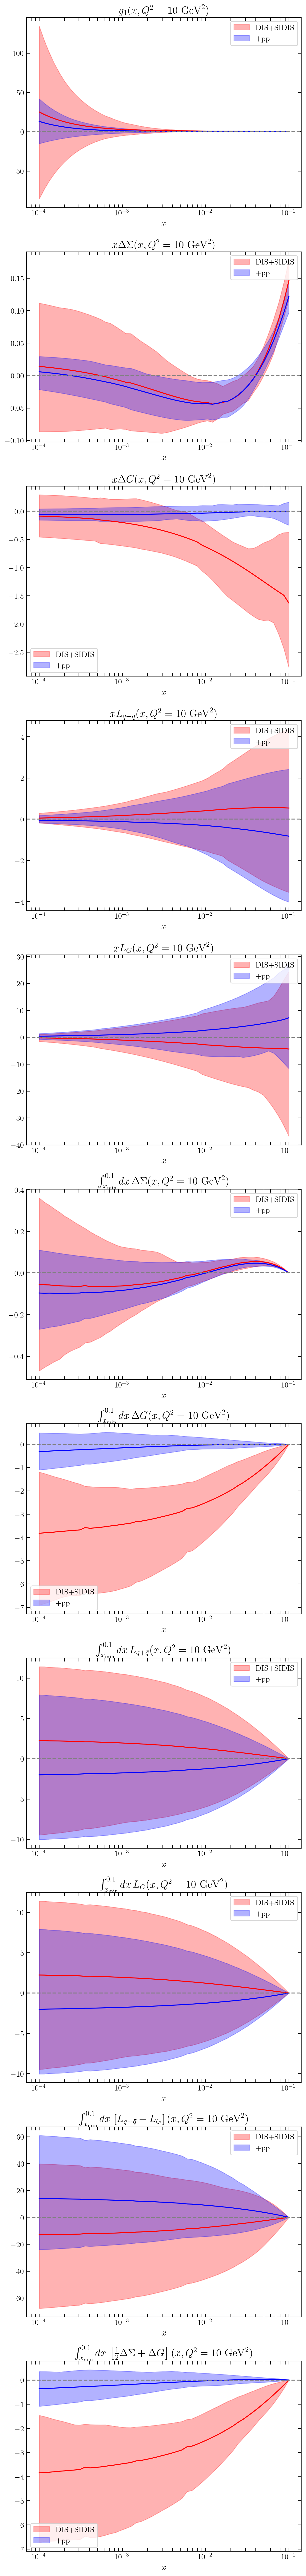

In [15]:
# plot g1(x) and \Delta \Sigma replicas
asp_ratio = 4/3
psize = 5
nplots = 3
nplots += 2
nplots += 6
fig, axs = plt.subplots(nplots, 1, figsize=(asp_ratio*psize, psize*nplots))

plot_bands = True

colors = ['red', 'blue']
labels = ['DIS+SIDIS', '+pp']
for ifit, fit in enumerate(['dis+sidis', '+pp']):
    for ipdf, pdf in enumerate(['g1', 'xsigma', 'xg']):
        
        if plot_bands:
            axs[ipdf].plot(x_values, hbands[fit][pdf]['mean'], color=colors[ifit])
            axs[ipdf].fill_between(x_values, hbands[fit][pdf]['lower'], hbands[fit][pdf]['upper'], color=colors[ifit], alpha=0.3, label=labels[ifit])
        else:
            for irep, rep in enumerate(hdata[fit][pdf]):
                if irep == 0:
                    axs[ipdf].plot(x_values, rep, color=colors[ifit], alpha=0.2, label=labels[ifit])
                else:
                    axs[ipdf].plot(x_values, rep, color=colors[ifit], alpha=0.2)


    for ipdf, pdf in enumerate(['xLq', 'xLG']):
        ipdf += 3
        
        if plot_bands:
            axs[ipdf].plot(x_values, obands[fit][pdf]['mean'], color=colors[ifit])
            axs[ipdf].fill_between(x_values, obands[fit][pdf]['lower'], obands[fit][pdf]['upper'], color=colors[ifit], alpha=0.3, label=labels[ifit])
        else:
            for irep, rep in enumerate(odata[fit][pdf]):
                if irep == 0:
                    axs[ipdf].plot(x_values, rep, color=colors[ifit], alpha=0.2, label=labels[ifit])
                else:
                    axs[ipdf].plot(x_values, rep, color=colors[ifit], alpha=0.2)


    for ipdf, pdf in enumerate(['DeltaSigma', 'DeltaG', 'Lq', 'LG', 'oam', 'helicity']):
        ipdf += 5
        
        if plot_bands:
            axs[ipdf].plot(x_values, intbands[fit][pdf]['mean'], color=colors[ifit])
            axs[ipdf].fill_between(x_values, intbands[fit][pdf]['lower'], intbands[fit][pdf]['upper'], color=colors[ifit], alpha=0.3, label=labels[ifit])
        else:
            for irep, rep in enumerate(intdata[fit][pdf]):
                if irep == 0:
                    axs[ipdf].plot(x_values, rep, color=colors[ifit], alpha=0.2, label=labels[ifit])
                else:
                    axs[ipdf].plot(x_values, rep, color=colors[ifit], alpha=0.2)



axs[0].axhline(y=0, color='grey', linestyle='--')
axs[0].set_xlabel(r'$x$')
axs[0].set_title(r'$g_1(x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[0].legend()
axs[0].semilogx()
# axs[0].set_ylim([10, 3*10**7])
axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

    
axs[1].axhline(y=0, color='grey', linestyle='--')
axs[1].set_xlabel(r'$x$')
axs[1].set_title(r'$x \Delta \Sigma(x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[1].legend()
axs[1].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

    
axs[2].axhline(y=0, color='grey', linestyle='--')
axs[2].set_xlabel(r'$x$')
axs[2].set_title(r'$x \Delta G(x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[2].legend()
axs[2].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[3].axhline(y=0, color='grey', linestyle='--')
axs[3].set_xlabel(r'$x$')
axs[3].set_title(r'$x L_{q+\bar{q}}(x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[3].legend()
axs[3].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[3].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)


axs[4].axhline(y=0, color='grey', linestyle='--')
axs[4].set_xlabel(r'$x$')
axs[4].set_title(r'$x L_G(x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[4].legend()
axs[4].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[4].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)



axs[5].axhline(y=0, color='grey', linestyle='--')
axs[5].set_xlabel(r'$x$')
axs[5].set_title(r'$ \int \displaylimits_{x_{\mathrm{min}}}^{0.1} dx \, \Delta \Sigma (x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[5].legend()
axs[5].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[5].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[6].axhline(y=0, color='grey', linestyle='--')
axs[6].set_xlabel(r'$x$')
axs[6].set_title(r'$ \int \displaylimits_{x_{\mathrm{min}}}^{0.1} dx \, \Delta G (x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[6].legend()
axs[6].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[6].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[7].axhline(y=0, color='grey', linestyle='--')
axs[7].set_xlabel(r'$x$')
axs[7].set_title(r'$ \int \displaylimits_{x_{\mathrm{min}}}^{0.1} dx \, L_{q+\bar{q}} (x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[7].legend()
axs[7].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[7].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[8].axhline(y=0, color='grey', linestyle='--')
axs[8].set_xlabel(r'$x$')
axs[8].set_title(r'$\int \displaylimits_{x_{\mathrm{min}}}^{0.1} dx \, L_G(x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[8].legend()
axs[8].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[8].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[9].axhline(y=0, color='grey', linestyle='--')
axs[9].set_xlabel(r'$x$')
axs[9].set_title(r'$\int \displaylimits_{x_{\mathrm{min}}}^{0.1} dx \, \left[ L_{q+\bar{q}} + L_G \right] (x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[9].legend()
axs[9].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[9].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)

axs[10].axhline(y=0, color='grey', linestyle='--')
axs[10].set_xlabel(r'$x$')
axs[10].set_title(r'$\int \displaylimits_{x_{\mathrm{min}}}^{0.1} dx \, \left[ \frac{1}{2} \Delta \Sigma + \Delta G \right] (x, Q^2 = 10\,\,\mathrm{GeV}^2)$')
axs[10].legend()
axs[10].semilogx()
# ax.set_ylim([10, 3*10**7])
axs[10].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)



plt.tight_layout()
plt.show()


# if plot_bands:
#     fig.savefig('plots/ppdf_band.pdf', dpi=400, bbox_inches="tight")
# else:
#     fig.savefig('plots/ppdf_lines.pdf', dpi=400, bbox_inches="tight")




In [45]:
# compute the azimuthal correlations

dijet_kins = dijet.Kinematics(Q=6, z=0.4, x=0.01, s=65**2, delta=0.2)
dijet_kins.y = (dijet_kins.Q**2)/(dijet_kins.s*dijet_kins.x)
assert dijet_kins.y <= 1, 'y > 1'

pT_values = np.linspace(1,40,100)
dj = dijet.DIJET(fix_moments=False)
dj_pp = dijet.DIJET(fix_moments=False)
dj_pp.load_params('replica_params_pp.csv')

replicas = {}
replicas['dis+sidis'] = []
replicas['+pp'] = []

# nrep = random.randint(1,398)
for irep in range(398):
    if irep > 100: break
    print(irep)
    # nrep = random.randint(1,398)
    
    dj.set_params(irep+1)
    dj_pp.set_params(irep+1)

    rep_dis = {}
    rep_dis['<1>'] = []
    rep_dis['<cos(phi_Dp)>'] = []
    rep_dis['<cos(phi_Dp)cos(phi_kp)>'] = []
    rep_dis['<sin(phi_Dp)sin(phi_kp)>'] = []

    rep_pp = {}
    rep_pp['<1>'] = []
    rep_pp['<cos(phi_Dp)>'] = []
    rep_pp['<cos(phi_Dp)cos(phi_kp)>'] = []
    rep_pp['<sin(phi_Dp)sin(phi_kp)>'] = []
    
    for pT in pT_values:
        dijet_kins.pT = pT

        rep_dis['<1>'].append(dj.get_correlation(dijet_kins, '<1>'))
        rep_dis['<cos(phi_Dp)>'].append(dj.get_correlation(dijet_kins, '<cos(phi_Dp)>'))
        rep_dis['<cos(phi_Dp)cos(phi_kp)>'].append(dj.get_correlation(dijet_kins, '<cos(phi_Dp)cos(phi_kp)>'))
        rep_dis['<sin(phi_Dp)sin(phi_kp)>'].append(dj.get_correlation(dijet_kins, '<sin(phi_Dp)sin(phi_kp)>'))

        rep_pp['<1>'].append(dj_pp.get_correlation(dijet_kins, '<1>'))
        rep_pp['<cos(phi_Dp)>'].append(dj_pp.get_correlation(dijet_kins, '<cos(phi_Dp)>'))
        rep_pp['<cos(phi_Dp)cos(phi_kp)>'].append(dj_pp.get_correlation(dijet_kins, '<cos(phi_Dp)cos(phi_kp)>'))
        rep_pp['<sin(phi_Dp)sin(phi_kp)>'].append(dj_pp.get_correlation(dijet_kins, '<sin(phi_Dp)sin(phi_kp)>'))

    replicas['dis+sidis'].append(rep_dis)
    replicas['+pp'].append(rep_pp)

    np.save('predictions/dsa_corrs.npy', replicas, allow_pickle=True)


loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-etamax15-rc/
loaded params from replica_params_old.csv
loaded replica 1
loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-etamax15-rc/
loaded params from replica_params_old.csv
loaded replica 1
loaded params from replica_params_pp.csv
0
loaded replica 1
loaded replica 1
1
loaded replica 2
loaded replica 2
2
loaded replica 3
loaded replica 3
3
loaded replica 4
loaded replica 4
4
loaded replica 5
loaded replica 5
5
loaded replica 6
loaded replica 6
6
loaded replica 7
loaded replica 7
7
loaded replica 8
loaded replica 8
8
loaded replica 9
loaded replica 9
9
loaded replica 10
loaded replica 10
10
loaded replica 11
loaded

KeyboardInterrupt: 

In [47]:
# calculate bands for correlations

corr_data = np.load('predictions/dsa_corrs.npy', allow_pickle=True).item()
# corr_data = np.load('predictions/dsa_corrs_fixed_moments1.npy', allow_pickle=True).item()
# corr_data = np.load('predictions/dsa_corrs_fixed_helicity.npy', allow_pickle=True).item()

confid = 68

corr_bands = {}
for fit in ['dis+sidis', '+pp']:
    corr_bands[fit] = {}
    for obj in ['lower', 'upper', 'mean']:
        corr_bands[fit][obj] = {}

    for corr in corr_data['dis+sidis'][0].keys():
        corr_reps = [rep[corr] for rep in corr_data[fit]]
        corr_bands[fit]['lower'][corr] = np.percentile(corr_reps, 0.5*(100-confid), axis=0)
        corr_bands[fit]['upper'][corr] = np.percentile(corr_reps, 100 - 0.5*(100-confid), axis=0)
        corr_bands[fit]['mean'][corr] = np.mean(corr_reps, axis=0)



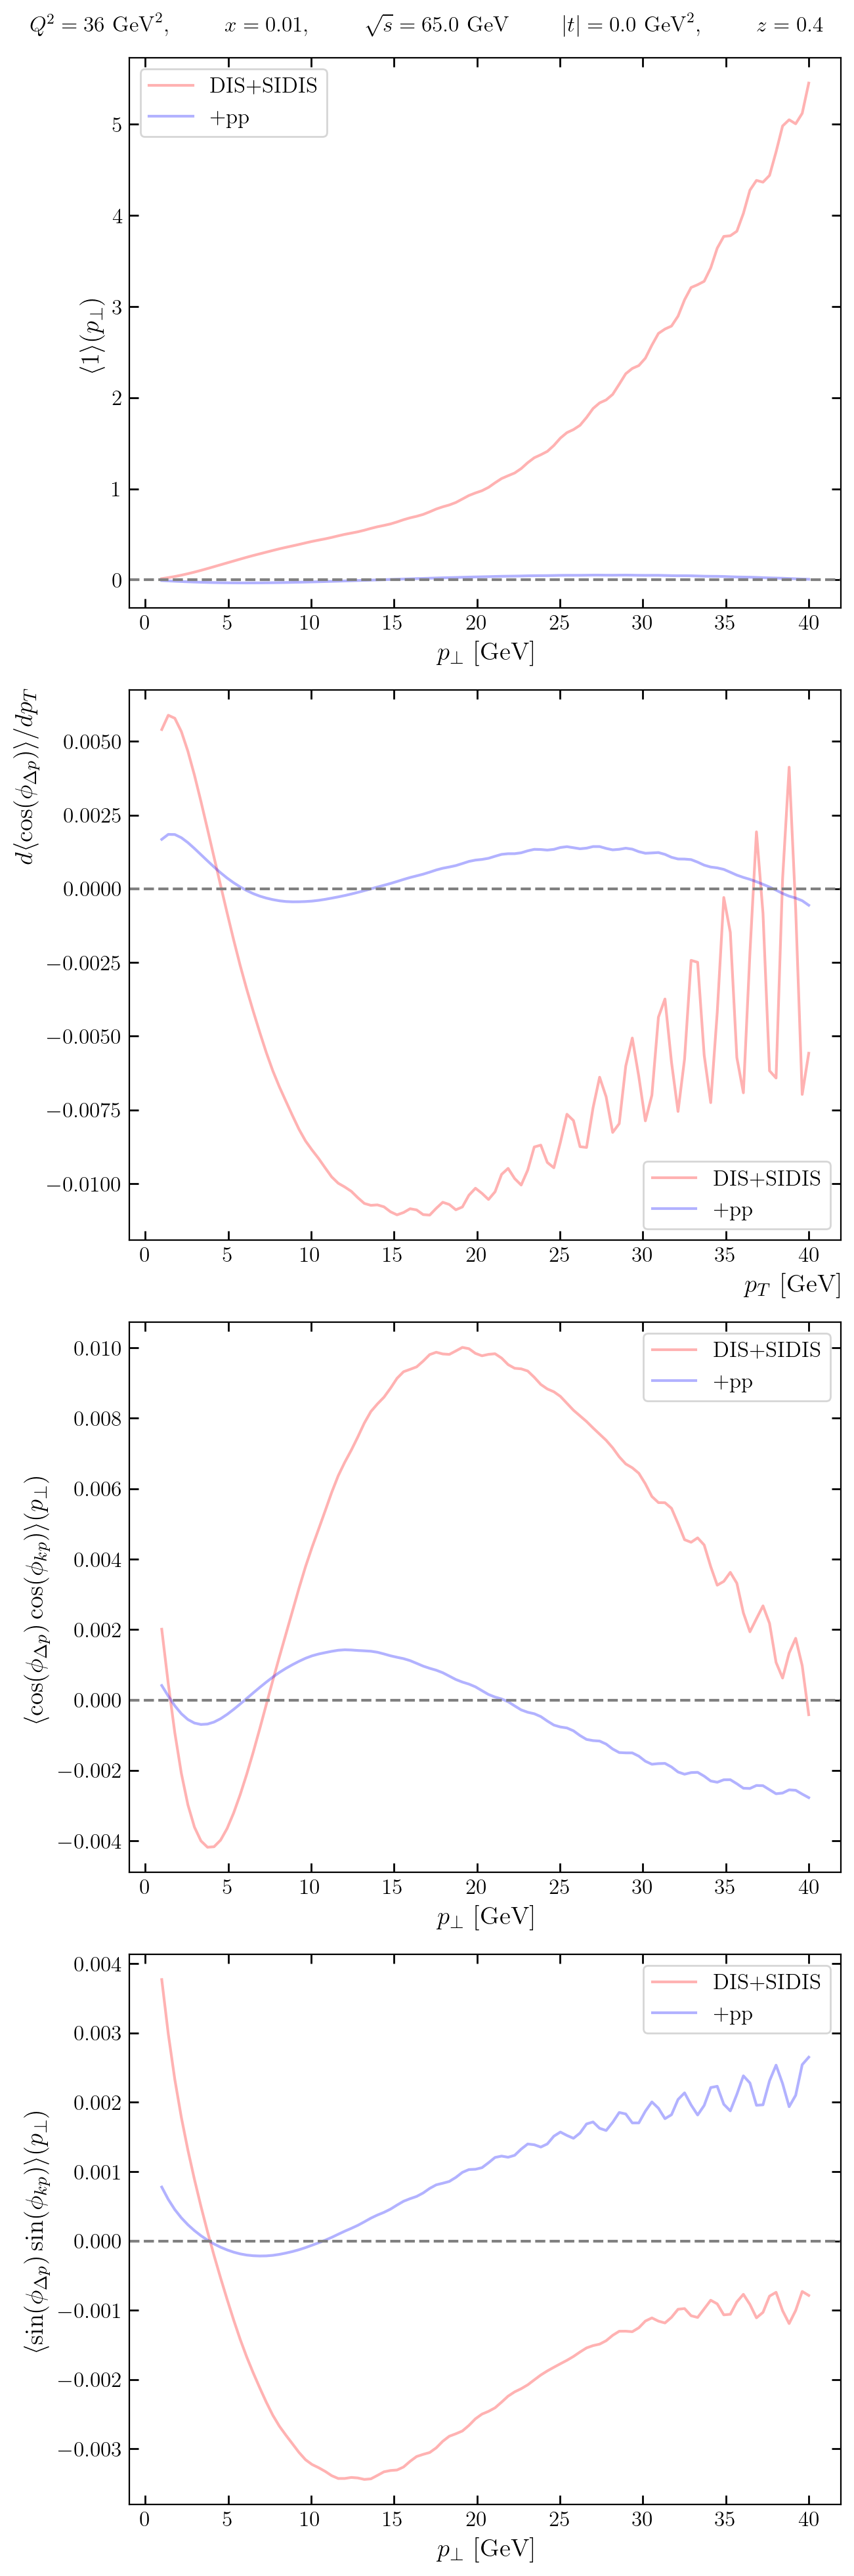

In [51]:
# plot azimuthal correlations
asp_ratio = 4/3
psize = 5

dijet_kins = dijet.Kinematics(Q=6, z=0.4, x= 0.01, s=65**2, delta=0.2)
dijet_kins.y = (dijet_kins.Q**2)/(dijet_kins.s*dijet_kins.x)
assert dijet_kins.y <= 1, 'y > 1'

pT_values = np.linspace(1,40,100)

fig, axs = plt.subplots(4, 1, figsize=(asp_ratio*psize, psize*4))

dijet_str = fr'$Q^2={round(dijet_kins.Q**2,1)} \,\, \mathrm{{GeV}}^2, \hspace{{1cm}} x={dijet_kins.x}, \hspace{{1cm}}\sqrt{{s}}={np.sqrt(dijet_kins.s)} \,\, \mathrm{{GeV}}$'
dijet_str += fr'$\hspace{{1cm}} |t| ={round(dijet_kins.delta**2,1)}\,\, \mathrm{{GeV}}^2, \hspace{{1cm}} z={dijet_kins.z}$'
fig.suptitle(dijet_str, fontsize=12)

# pT_values = np.linspace(1,20,50)
plot_bands = False 

colors = ['red', 'blue']
labels = ['DIS+SIDIS', '+pp']

for ifit, fit in enumerate(['dis+sidis','+pp']):
    
    for icorr, corr in enumerate(corr_data[fit][0].keys()):
        if plot_bands:
            axs[icorr].plot(pT_values, corr_bands[fit]['mean'][corr], color=colors[ifit])
            axs[icorr].fill_between(pT_values, corr_bands[fit]['lower'][corr], corr_bands[fit]['upper'][corr], color=colors[ifit], alpha=0.3, label=labels[ifit])
        
        else:
            for irep, rep in enumerate(corr_data[fit]):
                if irep > 0: continue
                if irep == 0:
                    axs[icorr].plot(pT_values, rep[corr], alpha=0.3, color=colors[ifit], label=labels[ifit])
                else: 
                    axs[icorr].plot(pT_values, rep[corr], alpha=0.3, color=colors[ifit])

# axs[0].axhline(y=1, color='grey', linestyle=':')
# axs[0].axhline(y=-1, color='grey', linestyle=':')
axs[0].axhline(y=0, color='grey', linestyle='--')
axs[0].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0].set_ylabel(fr'$ \langle 1 \rangle (p_\perp)$')
axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[0].legend()
# axs[0].semilogy()
# axs[0].set_ylim([-1.5, 1.5])

axs[1].axhline(y=0, color='grey', linestyle='--')
axs[1].set_xlabel(r'$p_T$ [GeV]', loc='right')
axs[1].set_ylabel(fr'$ d \langle \cos(\phi_{{\Delta p}}) \rangle /d p_T $', loc='top')
axs[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[1].legend()
# axs[1].set_ylim([-1.5, 1.5])


axs[2].axhline(y=0, color='grey', linestyle='--')
axs[2].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[2].set_ylabel(fr'$ \langle \cos(\phi_{{\Delta p}}) \cos(\phi_{{k p}}) \rangle (p_\perp)$')
axs[2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[2].legend()
# axs[2].set_ylim([-1.5, 1.5])

axs[3].axhline(y=0, color='grey', linestyle='--')
axs[3].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[3].set_ylabel(fr'$ \langle \sin(\phi_{{\Delta p}}) \sin(\phi_{{k p}})  \rangle (p_\perp)$')
axs[3].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[3].legend()
# axs[3].set_ylim([-1.5, 1.5])
# axs[1].legend()
    # axs[0].semilogy()
    # ax.set_ylim([10, 10**8])

plt.tight_layout(rect=[0, 0, 1, 0.99]) 
plt.show()


if plot_bands:
    fig.savefig('plots/corr_band.pdf', dpi=400, bbox_inches="tight")
else:
    fig.savefig('plots/corr_lines.pdf', dpi=400, bbox_inches="tight")


In [13]:
# make Fourier-Bessel transform data

fb_kins = dijet.Kinematics()
fb_kins.Q = 9
fb_kins.s = 100**2
fb_kins.z = 0.4
fb_kins.pT = 20.0

dj = dijet.DIJET()
dj_bad = dijet.DIJET(old_rap=True)

values = {}
values['pT'] = np.linspace(1, 50, 200)
values['x'] = np.logspace(-3.5, -2, 100)


fbs = {}
fbs['N'] = {}
fbs['Qu'] = {}


fbs_bad = {}
fbs_bad['N'] = {}
fbs_bad['Qu'] = {}

for var in ['pT', 'x']: 
    fbs['N'][var] = []
    fbs['Qu'][var] = []

    fbs_bad['N'][var] = []
    fbs_bad['Qu'][var] = []

for irep in range(500):
    if irep > 30: break 
    print(irep)
    nrep = random.randint(1,398)
    dj.set_params(nrep)
    dj_bad.set_params(nrep)
    
    pfb_rep = []
    pfb_rep_bad = []
    fb_kins.x = 0.01
    w2 = (fb_kins.Q**2)*((1/fb_kins.x)-1)
    for pT in values['pT']:
        fb_kins.pT = pT

        if irep == 0:
            fbs['N']['pT'].append(dj.fourier_bessel(fb_kins, [[1,1,0,0]], 'N'))
            fbs_bad['N']['pT'].append(dj_bad.fourier_bessel(fb_kins, [[1,1,0,0]], 'N'))
    
        pfb_rep.append(dj.fourier_bessel(fb_kins, [[1,1,0,0]], 'Qu')/w2)
        pfb_rep_bad.append(dj_bad.fourier_bessel(fb_kins, [[1,1,0,0]], 'Qu')/w2)

    fbs['Qu']['pT'].append(pfb_rep)
    fbs_bad['Qu']['pT'].append(pfb_rep_bad)


    pfb_rep = []
    pfb_rep_bad = []
    fb_kins.pT = 20.0
    for x in values['x']:
        fb_kins.x = x

        w2 = (fb_kins.Q**2)*((1/x)-1)
        if irep == 0:
            fbs['N']['x'].append(dj.fourier_bessel(fb_kins, [[1,1,0,0]], 'N'))
            fbs_bad['N']['x'].append(dj_bad.fourier_bessel(fb_kins, [[1,1,0,0]], 'N'))
    
        pfb_rep.append(dj.fourier_bessel(fb_kins, [[1,1,0,0]], 'Qu')/w2)
        pfb_rep_bad.append(dj_bad.fourier_bessel(fb_kins, [[1,1,0,0]], 'Qu')/w2)

    fbs['Qu']['x'].append(pfb_rep)
    fbs_bad['Qu']['x'].append(pfb_rep_bad)
  

loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-etamax15-rc/
loaded params from replica_params_old.csv
loaded replica 1
Using ln(1/x) in argument of N!
loaded N(r^2, s) data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-etamax15-rc/
loaded params from replica_params_old.csv
loaded replica 1
0
loaded replica 377
loaded replica 377
1
loaded replica 301
loaded replica 301
2
loaded replica 359
loaded replica 359
3
loaded replica 177
loaded replica 177
4
loaded replica 8
loaded replica 8
5
loaded replica 320
loaded replica 320
6
loaded replica 209
loaded replica 209
7
loaded replica 29
loaded replica 29
8
loaded replica 113
loaded replica 113
9
loaded replica 39
loaded replica 39
10
loa

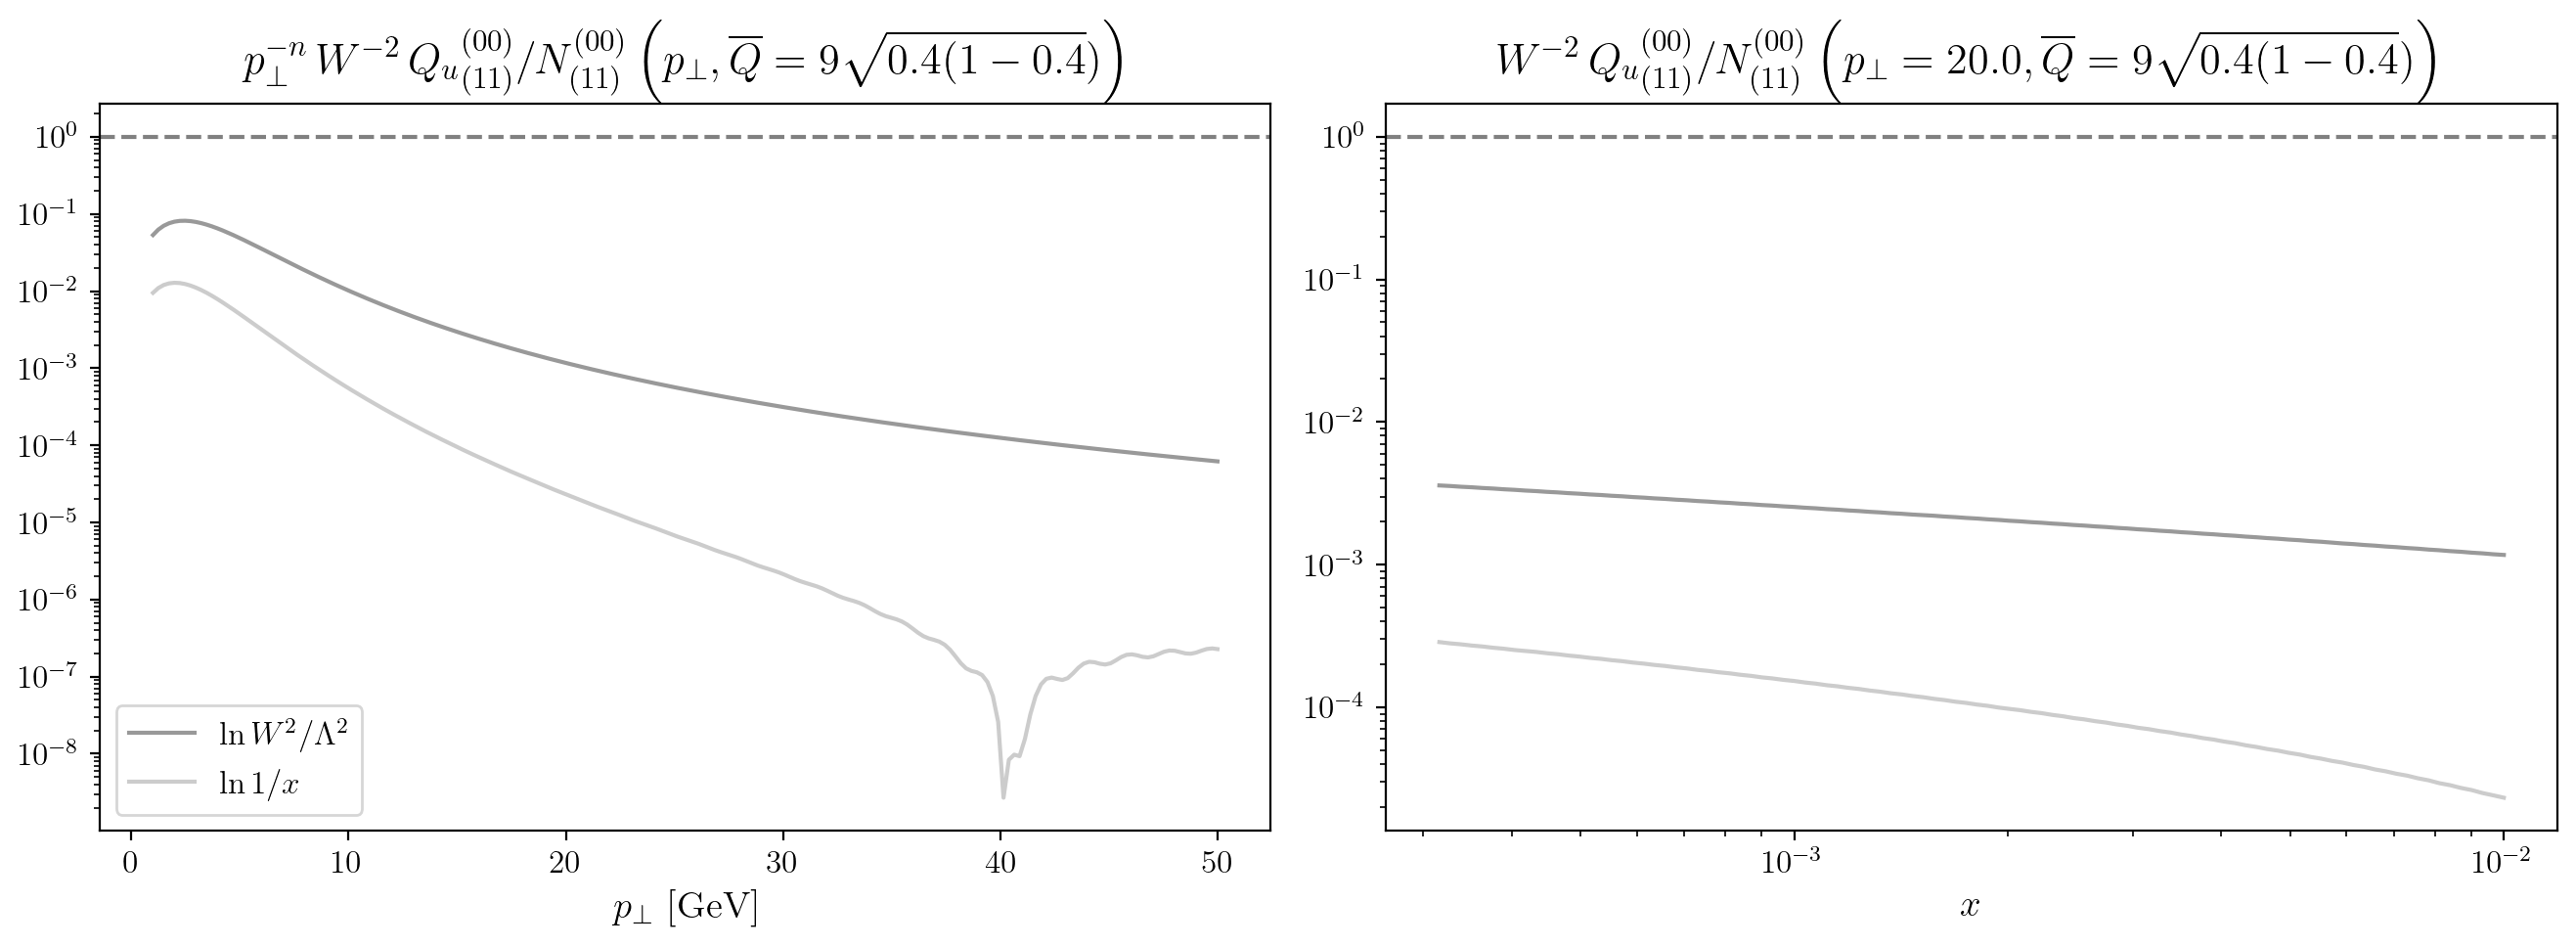

In [17]:
# plot FB transform 
asp_ratio = 4/3
psize = 5
fig, axs = plt.subplots(1, 2, figsize=(asp_ratio*psize*2, psize))

for irep in range(len(fbs['Qu']['x'])):
    if irep > 0: continue
    if irep == 0: 
        label0 = r'$n=0$'
        label1 = r'$n=1$'
        label2 = r'$n=2$'
        label3 = r'$n=3$'
    else:
        label0, label1, label2, label3 = None, None, None, None
        
    # axs[0].plot(values['pT'], ((1/values['pT'])**0)*(np.abs(fbs['Qu']['pT'][irep])/np.abs(fbs['N']['pT'])), alpha=0.4, color='blue', label=label0)
    # axs.plot(values['pT'], ((1/values['pT'])**1)*(np.abs(fbs['Qu'][irep])/np.abs(fbs['N'])), alpha=0.4, color='red', label=label1)
    # axs[0].plot(values['pT'], ((1/values['pT'])**2)*(np.abs(fbs['Qu']['pT'][irep])/np.abs(fbs['N']['pT'])), alpha=0.4, color='green', label=label2)
    # axs[0].plot(values['pT'], ((1/values['pT'])**3)*(np.abs(fbs['Qu']['pT'][irep])/np.abs(fbs['N']['pT'])), alpha=0.4, color='red', label=label3)

    axs[0].plot(values['pT'], np.abs(fbs['N']['pT']), alpha=0.4, color='black', label=r'$\ln W^2/\Lambda^2$')
    axs[0].plot(values['pT'], np.abs(fbs_bad['N']['pT']), alpha=0.4, color='gray', label=r'$\ln 1/x$')

    axs[1].plot(values['x'], np.abs(fbs['N']['x']), alpha=0.4, color='black')
    axs[1].plot(values['x'], np.abs(fbs_bad['N']['x']), alpha=0.4, color='gray')

    # axs[1].plot(values['x'], (np.abs(fbs['Qu']['x'][irep])/np.abs(fbs['N']['x'])), alpha=0.4, color='blue')


axs[0].axhline(y=1, color='grey', linestyle='--')
axs[0].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[0].legend()
axs[0].axes.set_title(fr'$p_\perp^{{-n}}\, W^{{-2}} \, {{Q_u}}_{{(11)}}^{{(00)}}/N_{{(11)}}^{{(00)}} \left( p_\perp, \overline{{Q}} = {fb_kins.Q}\sqrt{{{fb_kins.z}(1-{fb_kins.z}}}) \right)$')
axs[0].semilogy()

axs[1].axhline(y=1, color='grey', linestyle='--')
axs[1].set_xlabel(r'$x$')
# axs[1].legend()
axs[1].axes.set_title(fr'$W^{{-2}} \, {{Q_u}}_{{(11)}}^{{(00)}}/N_{{(11)}}^{{(00)}} \left( p_\perp={fb_kins.pT}, \overline{{Q}} = {fb_kins.Q}\sqrt{{{fb_kins.z}(1-{fb_kins.z}}}) \right)$')
axs[1].semilogy()
axs[1].semilogx()

plt.tight_layout()
plt.show()

# fig.savefig('plots/fb_ratio_ppreps.pdf', dpi=400, bbox_inches="tight")



In [69]:
# make data for FB contour plot

pT_values = np.linspace(1,30,100)
Q_values = np.linspace(1,10,100)
fb_kins = {'z': 0.4, 'x': 0.01} 

pT_grid = np.zeros((100, 100))
Q_grid = np.zeros((100, 100))
fb_grid = np.zeros((100, 100))

dj = dutils.DIJET(1)

for i, pT in enumerate(pT_values):
    for j, Q in enumerate(Q_values):

        pT_grid[i,j] = pT
        Q_grid[i,j] = Q*np.sqrt(0.4*(1-0.4))

        fb_kins['pT'] = pT
        fb_kins['Q'] = Q
        
        fb_value = np.log(np.abs(dj.fourier_bessel(fb_kins, [[1,1,0,0]], 'N')))
        fb_grid[i,j] = fb_value
        

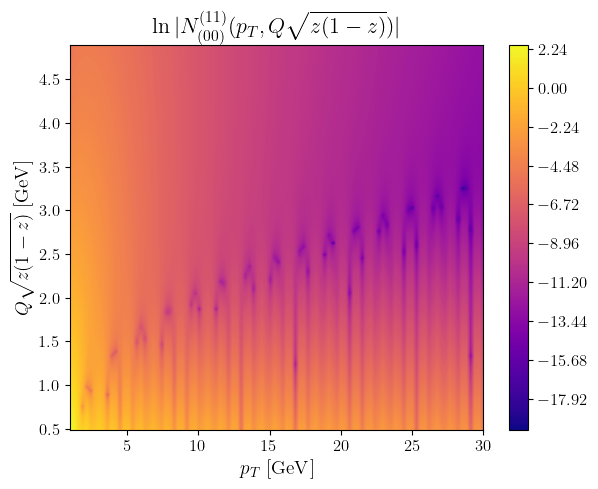

In [111]:
# make fb contour plot
asp_ratio = 4/3
psize = 5
fig, ax = plt.subplots(1, 1, figsize=(asp_ratio*psize, psize))

# ax.contour(pT_grid, Q_grid, fb_grid, levels=10, colors='black')
contour = ax.contourf(pT_grid, Q_grid, fb_grid, levels=300, cmap='plasma')  # More levels = smoother
cbar = fig.colorbar(contour, ax=ax)
ax.set_xlabel(r'$p_T\,\,[\mathrm{GeV}]$')
ax.set_ylabel(r'$Q \sqrt{z(1-z)} \,\,[\mathrm{GeV}]$')
ax.set_title(r'$\ln|N^{(11)}_{(00)} (p_T, Q \sqrt{z(1-z)})|$')

fig.savefig('fb_oscillation_map.png', dpi=700)

plt.show()

In [21]:
# compare IR regulating functions
pT_values = np.linspace(1,10,100)

zetas_g = [5, 10, 20]
zetas_s = [1, 2, 3]
cuts = [0, -1, -2]
test_r0 = 0.8

testIR_kins = {'Q':np.sqrt(5), 'z': 0.4, 'x': 0.01, 's': 100**2, 'delta':0.2, 'phi_Dp':0.0, 'phi_kp':0.0}
testIR_kins['y'] = (testIR_kins['Q']**2)/(testIR_kins['s']*testIR_kins['x'])

# fourier_bessel(self, kvar, indices, amp, lamIR = 0.3, IR_reg = [None, 0])

testQ_gauss = [np.array([dj.fourier_bessel({'pT': ipT} | testIR_kins, [0,0,0,0], 'Qu', IR_reg = ['gauss', zeta]) for ipT in pT_values]) for zeta in zetas_g]
testQ_skin = [np.array([dj.fourier_bessel({'pT': ipT} | testIR_kins, [0,0,0,0], 'Qu', IR_reg = ['skin', zeta, test_r0]) for ipT in pT_values]) for zeta in zetas_s]
testQ_cut = [np.array([dj.fourier_bessel({'pT': ipT} | testIR_kins, [0,0,0,0], 'Qu', IR_reg = ['cut', icut]) for ipT in pT_values]) for icut in cuts]



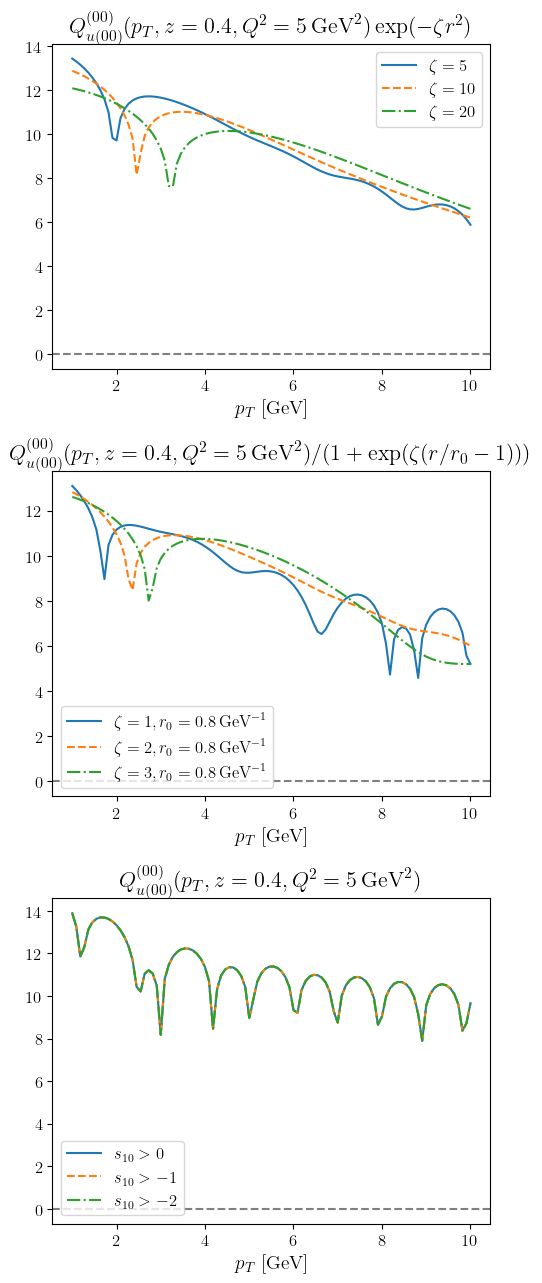

In [53]:
# IR regulator plots
fig, axes = plt.subplots(3,1, figsize=(5, 13))

lines = ['-', '--', '-.', ':']

for iz, zeta in enumerate(zetas_g):
    axes[0].plot(pT_values, np.log(np.abs(testQ_gauss[iz])), label = fr'$\zeta = {zeta}$', linestyle = lines[iz])

axes[0].axhline(y=0, color='grey', linestyle='--')
axes[0].set_xlabel(r'$p_{T}$ [GeV]')
axes[0].set_title(fr'$Q_{{u(00)}}^{{(00)}}(p_T, z={testIR_kins['z']}, Q^2={round(testIR_kins['Q']**2)}\,\mathrm{{GeV}}^2) \exp(-\zeta r^2)$')
axes[0].legend()
# axes[0].semilogy()

for iz, zeta in enumerate(zetas_s):
    axes[1].plot(pT_values, np.log(np.abs(testQ_skin[iz])), label = fr'$\zeta = {zeta}, r_0 = {test_r0}\, \mathrm{{GeV}}^{{-1}}$', linestyle = lines[iz])

axes[1].axhline(y=0, color='grey', linestyle='--')
axes[1].set_xlabel(r'$p_{T}$ [GeV]')
axes[1].set_title(fr'$Q_{{u(00)}}^{{(00)}}(p_T, z={testIR_kins['z']}, Q^2={round(testIR_kins['Q']**2)}\,\mathrm{{GeV}}^2)/(1 + \exp(\zeta (r/r_0 -1)))$')
axes[1].legend()
# axes[0].semilogy()

for ic, cut in enumerate(cuts):
    axes[2].plot(pT_values, np.log(np.abs(testQ_cut[ic])), label = fr'$s_{{10}} > {cut}$', linestyle = lines[ic])

axes[2].axhline(y=0, color='grey', linestyle='--')
axes[2].set_xlabel(r'$p_{T}$ [GeV]')
axes[2].set_title(fr'$Q_{{u(00)}}^{{(00)}}(p_T, z={testIR_kins['z']}, Q^2={round(testIR_kins['Q']**2)}\,\mathrm{{GeV}}^2)$')
axes[2].legend()
# axes[0].semilogy()

plt.tight_layout()
plt.show()


# fig.savefig(f"IR_regs{tag}.png")




In [75]:
# make random ICs
import pandas as pd 
pheader = [f'{amp}{basis}' for amp in ['I3u', 'I3d', 'I3s', 'I3T', 'I4', 'I5'] for basis in ['eta', 's10', '1']]
mom_params = {}

for param in ['nrep'] + pheader:
    mom_params[param] = []

for irep in range(1, 501):
    mom_params['nrep'].append(irep)
    for param in pheader:
        mom_params[param].append(random.uniform(-10, 10))

mdf = pd.DataFrame(mom_params)
mdf.to_csv('random_moment_params.csv', index=False)  # index=False avoids writing row numbers

In [79]:
pd.read_csv('random_moment_params.csv')

,nrep,I3ueta,I3us10,I3u1,I3deta,I3ds10,I3d1,I3seta,I3ss10,I3s1,I3Teta,I3Ts10,I3T1,I4eta,I4s10,I41,I5eta,I5s10,I51
0,1,-0.233161,-8.441950,4.440738,9.521638,-1.198563,-7.250368,-4.563057,6.892894,-7.135039,-0.955240,2.400844,-0.426206,-2.197369,-5.878207,9.713155,-1.907791,-7.179609,-1.119504
1,2,7.926151,-1.925530,-8.478675,4.778528,-2.793028,0.219075,0.711521,2.278702,5.465573,1.739512,-9.253983,5.517812,7.871435,6.605634,1.772080,9.204480,0.928931,7.069918
2,3,-2.191303,1.299846,4.487529,-5.530920,-6.269342,5.415117,-5.336438,9.445221,3.402558,-2.256943,2.287362,-0.368075,-8.991026,-3.898304,-1.138223,-1.941743,-2.576328,-3.873678
3,4,-0.620643,-3.198441,-3.411089,0.459056,8.927872,2.021281,-5.059710,3.716956,-7.284013,4.785588,8.366132,-0.327111,6.402360,-6.723940,6.827262,6.556735,3.520532,-2.634950
4,5,-0.532768,0.055846,-4.200429,7.261529,-5.131747,7.528887,9.529452,7.877340,7.330258,-1.251460,-6.031752,-5.475601,-4.170485,5.703163,-0.225521,5.689868,-0.473317,2.423736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,2.604705,8.890576,6.769105,-7.556818,-0.062987,0.796463,0.034246,-2.087374,-7.450280,6.336207,-4.414169,6.640788,-8.822346,6.313401,5.881990,-6.453348,-6.592831,4.622757
496,497,7.614705,-1.359905,7.488846,-1.274787,-2.340048,3.602839,6.483368,4.452745,9.668606,3.723766,-2.102401,-2.196954,-7.298348,-6.296149,-8.224825,0.399202,-3.855599,-8.126705
497,498,9.064430,-0.713707,3.691234,1.055069,0.574826,8.743495,9.451582,-2.042193,9.051216,3.783292,5.589847,7.855697,1.843137,-0.946785,-7.265825,-8.302117,-2.956127,8.963371
498,499,-8.404192,-9.721999,9.092299,-3.107878,-1.130836,5.472826,-1.792081,2.618755,6.039610,-0.569635,6.194200,7.911050,-3.643526,6.112623,8.223609,4.907045,4.156769,-3.655354
